# <신장 종양 적출에 따른 손실체적(RAIV) 예측>
### 신장 종양 평가지표(PADUA, Renal..)를 활용한 최소한의 필요한 종양 적출 체적 예측

- 과거에는 신장에 발생한 악성종양을 제거할 때 한쪽 신장을 모두 제거해왔으나, 최근에는 신장 한쪽을 제거한 경우 수술 후 신부전·심혈관질환 각종 대사성 질환의 빈도가 증가한다는 보고가 있어 가능하면 "신장을 보존하는것이 최근 경향"
- 신장은 출혈 위험이 크며, 생명 유지에 중요한 기능을 하는 장기이므로  신장의 기능을 보존할 수 있게 신장 "수술의 목표는 최소 절개 및 최대 보존"
#### 목표: 신장을 최대한 보존해 합병증을 줄임으로써 만성질환 예방과 삶의 질을 높여 환자들에게 큰 도움이 될 것

- 그러나 의학 전문가가 아니기에 기본 의학 지식 공부하더라도!
## 부제: 도메인 지식이 없어도 데이터만으로도 특성 파악하여 예측하기
- 특성 파악하는 방법
1. 결측치, 이상치 처리 / 기본통계분석 / 클래스 불균형 이해
2. 특성 분포 및 시각화:특성의 분포를 히스토그램이나 상자 그림 등을 사용(관계 이해를 위한 산점도)
3. 트리 기반 모델의 특성 중요도: DecisionTreeRegressor나 RandomForestRegressor와 같은 트리 기반 모델은 각 특성의 중요도
4. L1 정규화 (Lasso): L1 정규화를 사용한 선형 회귀 모델은 일부 특성의 가중치를 0으로 만들어 특성 선택을 자동
5. 다중회귀
6. 차원 축소 기법 적용: PCA 차원 축소 기법을 사용 데이터의 주성분을 분석하여 주요 특성
7. 재귀적 특성 제거 (RFE):모델을 훈련하고 가장 중요하지 않은 특성을 반복적으로 제거하여 최적의 특성을 선택하는 방법

### 1. 데이터 불러오기

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [31]:
padua_data = pd.read_csv('../data/kideny_PADUA_upload.csv')
renal_data = pd.read_csv('../data/kideny_RENAL_upload.csv')
treat_data = pd.read_csv('../data/kidney_treat_upload.csv')

#### RENAL(종양 크기,위치에 초점. 종양 형태 및 인근 구조 관계 간략 평가)
- 'serial' : 환자번호<br>
- 'Radius_RENAL' : 종양의 최장 반지름 길이(cm) -> T_size<br>
- 'Exophytic_RENAL' : 종양의 외성장 정도(%) -> T_exophytic<br>
- 'Nearness_RENAL' : 종양의 집배뇨관의 근접 정도 -> T_near_Ureter<br>
- 'APX_RENAL' : 종양의 위치(전/후방) -> T_APX<br>
- 'Location_RENAL' : 종양의 집배뇨관 기준 상대 위치 -> T_rel_Ureter<br>
- 'RENAL_total' : 최종 RENAL 복합성 점수 3점 척도(3~8점)<br>

#### PADUA(해부학적 측면 수술 전 측면과 치수)
- 'serial' : 환자번호<br>
- 'Tumor_PADUA' : 종양의 크기(cm) -> T_size<br>
- 'Exophytic_PADUA' : 종양의 외성장 비율(%) -> T_exophytic<br>
- 'Rim_PADUA' : 종양의 표면위치(외/내) -> T_surface_loc<br>
- 'Sinus_PADUA' : 신동과의 거리 -> T_Sinus_dt<br>
- 'Polarlocation_PADUA' : 종양의 세로 기준 위치 -> T_height_loc<br>
- 'Collectingsystem_PADUA' :사구체 침범 정도 -> T_GM_over<br>
- 'PADUA_total' : 총 PADUA 복합성 점수(3점 척도)(6~13점)

#### Treat
- 'serial' : 환자번호<br>
- 'RAIV' : 신장 종양 적출에 따른 손실 체적(cm^3)

In [32]:
treat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   serial  400 non-null    int64  
 1   RAIV_1  397 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [33]:
padua_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   serial                  400 non-null    int64  
 1   Tumor_PADUA             396 non-null    float64
 2   Exophytic_PADUA         395 non-null    float64
 3   Rim_PADUA               395 non-null    float64
 4   Sinus_PADUA             395 non-null    float64
 5   Polarlocation_PADUA     395 non-null    float64
 6   Collectingsystem_PADUA  395 non-null    float64
 7   PADUA_total             400 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 25.1 KB


In [34]:
renal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   serial           400 non-null    int64  
 1   Radius_RENAL     396 non-null    float64
 2   Exophytic_RENAL  395 non-null    float64
 3   Nearness_RENAL   395 non-null    float64
 4   APX_RENAL        394 non-null    float64
 5   Location_RENAL   395 non-null    float64
 6   RENAL_total      400 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 22.0 KB


### 2. 데이터 정리
- 중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기 

In [35]:
merged_data = pd.merge(padua_data, renal_data, on='serial')

In [36]:
merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1, inplace=True)

In [37]:
merged_result = pd.merge(merged_data, treat_data, on='serial')

- 컬럼명 변경

#### RENAL(종양 크기,위치에 초점. 종양 형태 및 인근 구조 관계 간략 평가)
- 'serial' : 환자번호<br>
- 'Radius_RENAL' : 종양의 최장 반지름 길이(cm) -> T_size<br>
- 'Exophytic_RENAL' : 종양의 외성장 정도(%) -> T_exophytic<br>
- 'Nearness_RENAL' : 종양의 집배뇨관의 근접 정도 -> T_near_Ureter<br>
- 'APX_RENAL' : 종양의 위치(전/후방) -> T_APX<br>
- 'Location_RENAL' : 종양의 집배뇨관 기준 상대 위치 -> T_rel_Ureter<br>
- 'RENAL_total' : 최종 RENAL 복합성 점수 3점 척도(3~8점)<br>

#### PADUA(해부학적 측면 수술 전 측면과 치수)
- 'serial' : 환자번호<br>
- 'Tumor_PADUA' : 종양의 크기(cm) -> T_size<br>
- 'Exophytic_PADUA' : 종양의 외성장 비율(%) -> T_exophytic<br>
- 'Rim_PADUA' : 종양의 표면위치(외/내) -> T_surface_loc<br>
- 'Sinus_PADUA' : 신동과의 거리 -> T_Sinus_dt<br>
- 'Polarlocation_PADUA' : 종양의 세로 기준 위치 -> T_height_loc<br>
- 'Collectingsystem_PADUA' :사구체 침범 정도 -> T_GM_over<br>
- 'PADUA_total' : 총 PADUA 복합성 점수(3점 척도)(6~13점)

#### Treat
- 'serial' : 환자번호<br>
- 'RAIV' : 신장 종양 적출에 따른 손실 체적(cm^3)

In [38]:
merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_GM_over','Sinus_PADUA':'T_Sinus_dt',
                            'Nearness_RENAL':'T_near_Ureter','APX_RENAL':'T_APX','Location_RENAL':'T_rel_Ureter','RAIV_1': 'RAIV'
                            }, inplace=True)

In [39]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   serial         400 non-null    int64  
 1   T_surface_loc  395 non-null    float64
 2   T_Sinus_dt     395 non-null    float64
 3   T_height_loc   395 non-null    float64
 4   T_GM_over      395 non-null    float64
 5   PADUA_total    400 non-null    int64  
 6   T_size         396 non-null    float64
 7   T_exophytic    395 non-null    float64
 8   T_near_Ureter  395 non-null    float64
 9   T_APX          394 non-null    float64
 10  T_rel_Ureter   395 non-null    float64
 11  RENAL_total    400 non-null    int64  
 12  RAIV           397 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 40.8 KB


- 결측치 제거

In [40]:
merged_data_result = merged_result.dropna()

In [41]:
merged_data_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389 entries, 0 to 399
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   serial         389 non-null    int64  
 1   T_surface_loc  389 non-null    float64
 2   T_Sinus_dt     389 non-null    float64
 3   T_height_loc   389 non-null    float64
 4   T_GM_over      389 non-null    float64
 5   PADUA_total    389 non-null    int64  
 6   T_size         389 non-null    float64
 7   T_exophytic    389 non-null    float64
 8   T_near_Ureter  389 non-null    float64
 9   T_APX          389 non-null    float64
 10  T_rel_Ureter   389 non-null    float64
 11  RENAL_total    389 non-null    int64  
 12  RAIV           389 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 42.5 KB


In [42]:
merged_data_result.head()

,serial,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,PADUA_total,T_size,T_exophytic,T_near_Ureter,T_APX,T_rel_Ureter,RENAL_total,RAIV
0,1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1
1,2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1
2,3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8
3,4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7
4,5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8


In [43]:
# Raiv에 대한 histogram
import plotly.express as px

fig=px.histogram(merged_data_result, x='RAIV')
fig.show()

In [44]:
merged_data_result.describe()
# 데이터 분포이해

,serial,T_surface_loc,T_Sinus_dt,T_height_loc,T_GM_over,PADUA_total,T_size,T_exophytic,T_near_Ureter,T_APX,T_rel_Ureter,RENAL_total,RAIV
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,202.228792,1.354756,1.318766,1.398458,1.311054,8.460154,1.208226,1.868895,1.920308,1.557841,1.799486,4.989717,27.196144
std,116.730333,0.479055,0.466598,0.490211,0.485253,1.682714,0.471162,0.718521,0.906064,0.497283,0.806481,1.428682,24.330815
min,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.500000
25%,104.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,10.800000
50%,202.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,2.000000,2.000000,2.000000,2.000000,5.000000,19.000000
75%,299.000000,2.000000,2.000000,2.000000,2.000000,9.000000,1.000000,2.000000,3.000000,2.000000,2.000000,6.000000,35.100000
max,412.000000,2.000000,2.000000,2.000000,3.000000,13.000000,3.000000,3.000000,3.000000,2.000000,3.000000,8.000000,154.800000


In [45]:
# 이상치 제거

# 상관관계

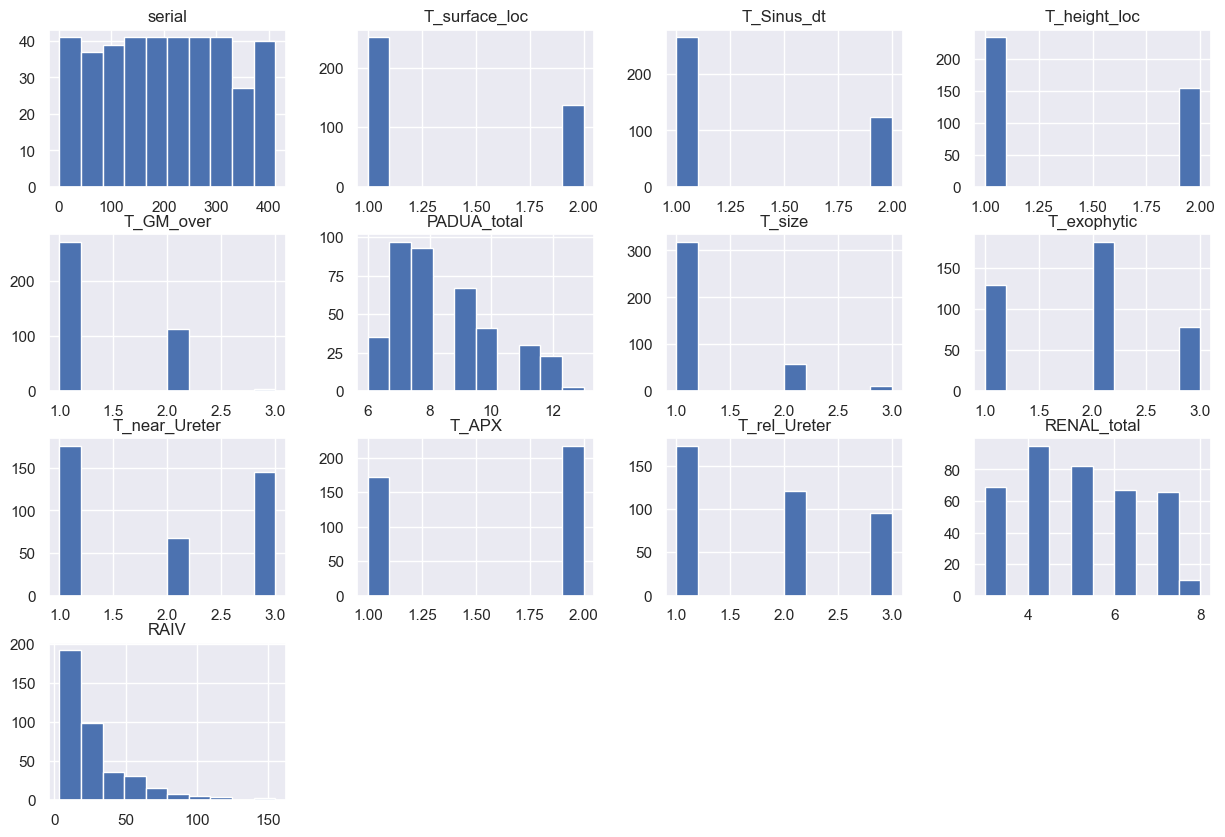

In [46]:
# 분포확인
merged_data_result.hist(bins=10, figsize=(15,10))
plt.show()

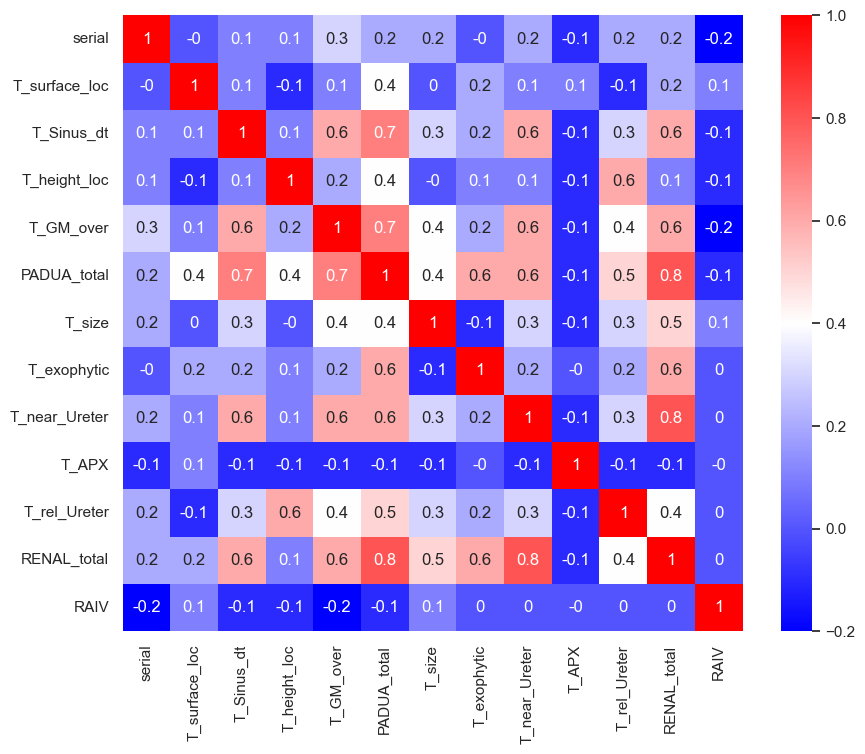

In [47]:
# corr() 함수이용해보기
corr = merged_data_result.corr().round(1)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=corr, annot=True, cmap='bwr');

In [48]:
# plt.figure(figsize=(12,6))
# sns.pairplot(data=merged_data_result);

# 데이터나누기

In [49]:
from sklearn.model_selection import train_test_split

X = merged_data_result.drop('RAIV', axis=1)  # 'RAIV_1' 열을 제외한 모든 열 선택
y = merged_data_result['RAIV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# y값 뷸균형 확인하기
import plotly.express as px

fig=px.histogram(y_train, x='RAIV')
fig.show()

In [51]:
# y값 뷸균형 확인하기
import plotly.express as px

fig=px.histogram(y_test, x='RAIV')
fig.show()

In [52]:
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

models=[]
models.append(('LinearRegression',LinearRegression()))
models.append(('DecisionTreeRegressor',DecisionTreeRegressor()))
models.append(('RandomForestRegressor',RandomForestRegressor()))
models.append(('AdaBoostRegressor',AdaBoostRegressor()))
models.append(('GradientBoostingRegressor',GradientBoostingRegressor()))
models.append(('XGBRegressor', XGBRegressor()))

# 제한없이 전체알고리즘

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

tr_result_mae = []
test_result_mae = []
tr_result_rmse = []
test_result_rmse = []
names = []

for name, model in models:
    names.append(name)
    # 모델 훈련
    model.fit(X_train, y_train)

    # 예측
    pred_tr = model.predict(X_train)
    pred_test = model.predict(X_test)

    # MAE 계산
    mae_tr = mean_absolute_error(y_train, pred_tr)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # RMSE 계산
    rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    
    # 결과를 리스트에 추가
    tr_result_mae.append(mae_tr)
    test_result_mae.append(mae_test)
    tr_result_rmse.append(rmse_tr)
    test_result_rmse.append(rmse_test)

# 결과를 DataFrame으로 정리
result_pd = pd.DataFrame({
    'Model': names,
    'train MAE': tr_result_mae,
    'test MAE': test_result_mae,
    'train RMSE': tr_result_rmse,
    'test RMSE': test_result_rmse
})

result_pd

,Model,train MAE,test MAE,train RMSE,test RMSE
0,LinearRegression,16.241615,16.609102,22.627190,21.959298
1,DecisionTreeRegressor,0.000000,17.415385,0.000000,27.863836
2,RandomForestRegressor,5.294109,13.904167,7.867171,20.539119
3,AdaBoostRegressor,16.146330,18.983315,18.545055,22.516351
4,GradientBoostingRegressor,7.594794,14.172556,9.836639,21.419283
5,XGBRegressor,0.541869,15.556282,0.769396,25.106868


# 교차 검증 train

In [54]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae = []
results_rmse = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)

    # MAE 계산
    cv_results_mae = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    cv_results_mae = -cv_results_mae
    results_mae.append(cv_results_mae)
    
    # RMSE 계산
    cv_results_rmse = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    cv_results_rmse = -cv_results_rmse
    results_rmse.append(cv_results_rmse)

    names.append(name)

# DataFrame 생성
result_pd = pd.DataFrame({
    'Model': names,
    'Mean MAE': [round(result.mean(), 4) for result in results_mae],
    'Std MAE': [round(result.std(), 4) for result in results_mae],
    'Mean RMSE': [round(result.mean(), 4) for result in results_rmse],
    'Std RMSE': [round(result.std(), 4) for result in results_rmse]
})

result_pd

,Model,Mean MAE,Std MAE,Mean RMSE,Std RMSE
0,LinearRegression,16.7834,2.5485,22.8663,4.8407
1,DecisionTreeRegressor,17.0131,1.3690,24.0747,2.2689
2,RandomForestRegressor,14.2251,1.6510,21.2134,2.9117
3,AdaBoostRegressor,16.8700,2.1866,22.4571,2.8515
4,GradientBoostingRegressor,14.2066,1.8070,21.2906,3.8089
5,XGBRegressor,15.5731,1.1355,22.9046,2.4480


# 교차검증 test

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae_test = []
results_rmse_test = []

for name, model in models:
    # MAE 계산
    pred_test = cross_val_predict(model, X_test, y_test, cv=5)
    mae_test = mean_absolute_error(y_test, pred_test)
    results_mae_test.append(mae_test)
    
    # RMSE 계산
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    results_rmse_test.append(rmse_test)

# DataFrame 생성
result_pd_test = pd.DataFrame({
    'Model': names,
    'MAE':  results_mae_test,
    'RMSE': results_rmse_test
})

result_pd_test

,Model,MAE,RMSE
0,LinearRegression,16.759408,22.179921
1,DecisionTreeRegressor,19.464103,28.785613
2,RandomForestRegressor,15.543897,22.487846
3,AdaBoostRegressor,17.258303,24.471608
4,GradientBoostingRegressor,17.613514,25.170082
5,XGBRegressor,17.056595,25.225438


### RandomForestRegressor() 모델 활용해서 성능 확인

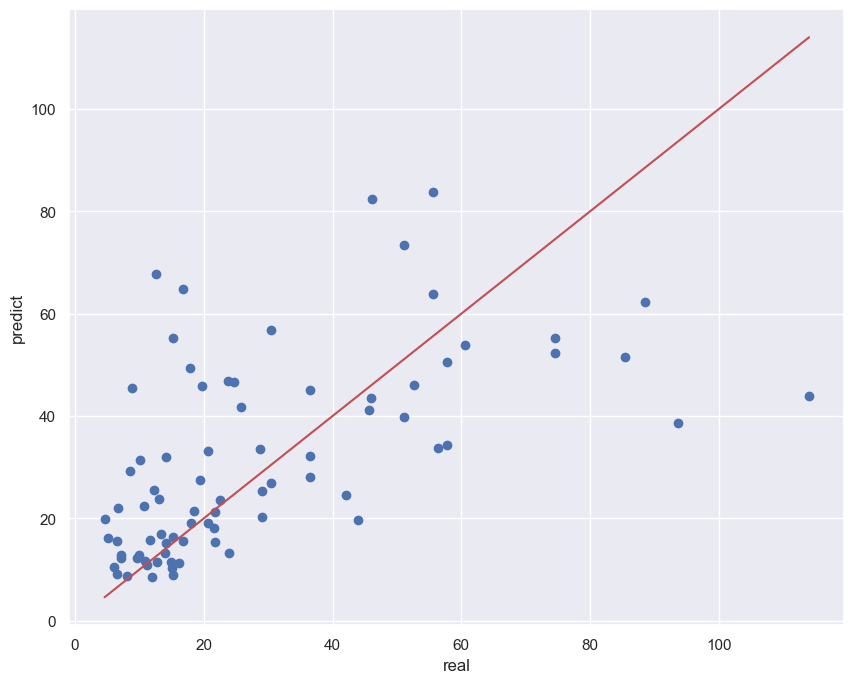

In [56]:
# 성능 확인

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r') 
plt.show()
# 값들이 빨간선 주위에 오는것이 좋음

# 군집 이용

In [57]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

cluster_range = range(2, 11)

optimal_clusters = 0
max_silhouette_score = -1

for n_clusters in cluster_range:
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    kmeans.fit(X_train)
    
    clusters = kmeans.predict(X_train)
    
    silhouette_avg = silhouette_score(X_train, clusters)
    
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_clusters = n_clusters

# Print the optimal number of clusters
print("Optimal number of clusters:", optimal_clusters)

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte
c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\joblib\externals\loky\back

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by set

Optimal number of clusters: 2


In [58]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# 학습된 모델을 이용하여 train 데이터에 대한 군집 레이블 예측
train_cluster_labels = kmeans.predict(X_train)

# 학습된 모델을 이용하여 test 데이터에 대한 군집 레이블 예측
test_cluster_labels = kmeans.predict(X_test)

print('train_cluster_labels :', train_cluster_labels)
print('test_cluster_labels : ', test_cluster_labels)

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



train_cluster_labels : [0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0
 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0
 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0
 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1
 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1
 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0
 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0]
test_cluster_labels :  [1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0
 0 0 0 1]


In [59]:
X_tr_1 = X_train[train_cluster_labels == 1]
X_test_1 = X_test[test_cluster_labels == 1]
y_tr_1 = y_train[train_cluster_labels == 1]
y_test_1 = y_test[test_cluster_labels == 1]

X_tr_0 = X_train[train_cluster_labels == 0]
X_test_0 = X_test[test_cluster_labels == 0]
y_tr_0 = y_train[train_cluster_labels == 0]
y_test_0 = y_test[test_cluster_labels == 0]

In [63]:
import plotly.graph_objects as go

# Plotly를 사용하여 시각화
fig = go.Figure()

# 훈련 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_0.iloc[:], mode='markers', marker=dict(color='blue'), name='Train Cluster 0'))

# 훈련 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_1.iloc[:], mode='markers', marker=dict(color='red'), name='Train Cluster 1'))

# 테스트 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_0.iloc[:], mode='markers', marker=dict(color='green'), name='Test Cluster 0'))

# 테스트 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_1.iloc[:], mode='markers', marker=dict(color='orange'), name='Test Cluster 1'))

fig.show()

In [64]:
import plotly.graph_objects as go

# Plotly를 사용하여 시각화
fig = go.Figure()

# 훈련 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_0.iloc[:], mode='markers', marker=dict(color='blue'), name='Train Cluster 0'))

# 훈련 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_tr_1.iloc[:], mode='markers', marker=dict(color='red'), name='Train Cluster 1'))

fig.show()

In [65]:
import plotly.graph_objects as go

# Plotly를 사용하여 시각화
fig = go.Figure()

# 테스트 군집 0에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_0.iloc[:], mode='markers', marker=dict(color='green'), name='Test Cluster 0'))

# 테스트 군집 1에 대한 산점도
fig.add_trace(go.Scatter(x=y_test_1.iloc[:], mode='markers', marker=dict(color='orange'), name='Test Cluster 1'))

fig.show()

---

## 군집0

In [66]:
from sklearn.metrics import r2_score, mean_squared_error

tr_result_mae = []
test_result_mae = []
tr_result_rmse = []
test_result_rmse = []
names = []

for name, model in models:
    # 모델 훈련
    model.fit(X_tr_0, y_tr_0)
    names.append(name)

    # 예측
    pred_tr = model.predict(X_tr_0)
    pred_test = model.predict(X_test_0)

    # MAE 계산
    mae_tr = mean_absolute_error(y_tr_0, pred_tr)
    mae_test = mean_absolute_error(y_test_0, pred_test)

    # RMSE 계산
    rmse_tr = np.sqrt(mean_squared_error(y_tr_0, pred_tr))
    rmse_test = np.sqrt(mean_squared_error(y_test_0, pred_test))

    # 결과를 리스트에 추가
    tr_result_mae.append(mae_tr)
    test_result_mae.append(mae_test)
    tr_result_rmse.append(rmse_tr)
    test_result_rmse.append(rmse_test)

# 결과를 DataFrame으로 정리
result_pd = pd.DataFrame({
    'Model': names,
    'train MAE': tr_result_mae,
    'test MAE': test_result_mae,
    'train RMSE': tr_result_rmse,
    'test RMSE': test_result_rmse
})

result_pd

,Model,train MAE,test MAE,train RMSE,test RMSE
0,LinearRegression,14.976262,17.156185,21.028164,23.092079
1,DecisionTreeRegressor,0.000000,18.391667,0.000000,26.551475
2,RandomForestRegressor,6.062034,16.122250,8.559339,22.005562
3,AdaBoostRegressor,14.036691,19.311493,16.531991,23.424536
4,GradientBoostingRegressor,5.928002,15.830496,7.701236,22.454874
5,XGBRegressor,0.071429,17.310960,0.098850,27.441594


- DecisionTreeRegressor 같은경우 규제를 주지 않아 과적합이 됨
### GradientBoostingRegressor() 모델 활용해서 성능 확인

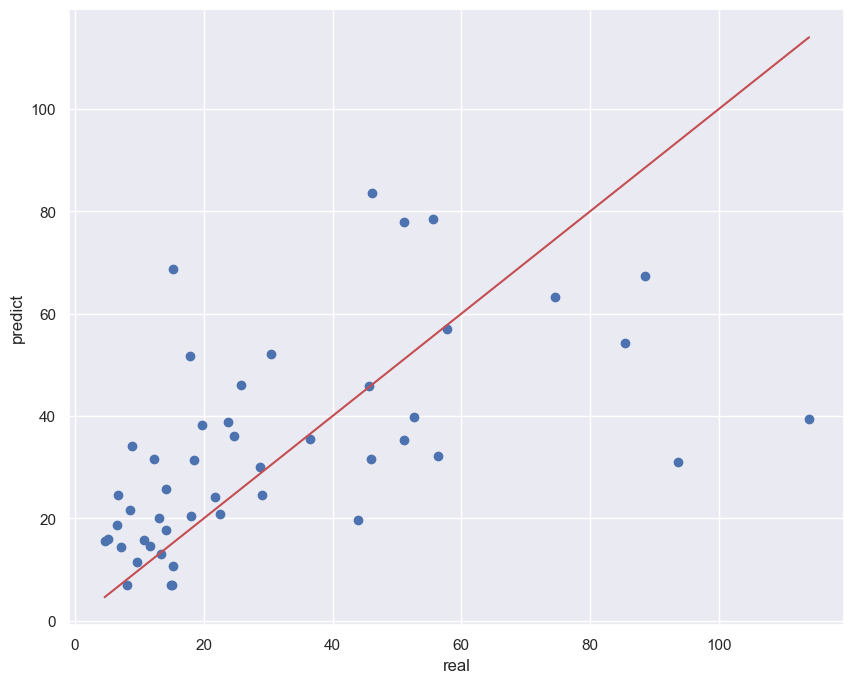

In [67]:
# 성능 확인

gb_model = GradientBoostingRegressor()
gb_model.fit(X_tr_0, y_tr_0)
predictions = gb_model.predict(X_test_0)

plt.scatter(y_test_0, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test_0), max(y_test_0)], [min(y_test_0), max(y_test_0)], 'r') 
plt.show()
# 값들이 빨간선 주위에 오는것이 좋음

## 교차검증 train

In [68]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae = []
results_rmse = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)

    # MAE 계산
    cv_results_mae = cross_val_score(model, X_tr_0, y_tr_0, cv=kfold, scoring='neg_mean_absolute_error')
    cv_results_mae = -cv_results_mae
    results_mae.append(cv_results_mae)
    
    # RMSE 계산
    cv_results_rmse = cross_val_score(model, X_tr_0, y_tr_0, cv=kfold,  scoring='neg_root_mean_squared_error')
    cv_results_rmse = -cv_results_rmse
    results_rmse.append(cv_results_rmse)

    names.append(name)

# DataFrame 생성
result_pd = pd.DataFrame({
    'Model': names,
    'Mean MAE': [round(result.mean(), 4) for result in results_mae],
    'Std MAE': [round(result.std(), 4) for result in results_mae],
    'Mean RMSE': [round(result.mean(), 4) for result in results_rmse],
    'Std RMSE': [round(result.std(), 4) for result in results_rmse]
})

result_pd

,Model,Mean MAE,Std MAE,Mean RMSE,Std RMSE
0,LinearRegression,16.2414,2.0075,22.0733,5.6328
1,DecisionTreeRegressor,18.5402,3.9052,27.6809,5.5197
2,RandomForestRegressor,15.5138,2.9927,22.5626,6.0889
3,AdaBoostRegressor,17.6076,2.9724,23.0823,6.3747
4,GradientBoostingRegressor,16.5926,3.5116,23.3081,6.7610
5,XGBRegressor,17.4470,3.5807,24.8170,7.2827


## 교차검증 test

In [69]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae_test = []
results_rmse_test = []

for name, model in models:
    # MAE 계산
    pred_test = cross_val_predict(model, X_test_0, y_test_0, cv=5)
    mae_test = mean_absolute_error(y_test_0, pred_test)
    results_mae_test.append(mae_test)
    
    # RMSE 계산
    rmse_test = np.sqrt(mean_squared_error(y_test_0, pred_test))
    results_rmse_test.append(rmse_test)

# DataFrame 생성
result_pd_test = pd.DataFrame({
    'Model': names,
    'MAE':  results_mae_test,
    'RMSE': results_rmse_test
})

result_pd_test

,Model,MAE,RMSE
0,LinearRegression,19.275875,24.959726
1,DecisionTreeRegressor,22.360417,31.084143
2,RandomForestRegressor,19.454146,26.324215
3,AdaBoostRegressor,21.296764,29.894396
4,GradientBoostingRegressor,21.949466,30.241779
5,XGBRegressor,21.934990,30.050374


---

## 군집1

In [70]:
from sklearn.metrics import r2_score, mean_squared_error

tr_result_mae = []
test_result_mae = []
tr_result_rmse = []
test_result_rmse = []
names = []

for name, model in models:
    # 모델 훈련
    model.fit(X_tr_1, y_tr_1)
    names.append(name)

    # 예측
    pred_tr = model.predict(X_tr_1)
    pred_test = model.predict(X_test_1)

    # MAE 계산
    mae_tr = mean_absolute_error(y_tr_1, pred_tr)
    mae_test = mean_absolute_error(y_test_1, pred_test)

    # RMSE 계산
    rmse_tr = np.sqrt(mean_squared_error(y_tr_1, pred_tr))
    rmse_test = np.sqrt(mean_squared_error(y_test_1, pred_test))

    # 결과를 리스트에 추가
    tr_result_mae.append(mae_tr)
    test_result_mae.append(mae_test)
    tr_result_rmse.append(rmse_tr)
    test_result_rmse.append(rmse_test)

# 결과를 DataFrame으로 정리
result_pd = pd.DataFrame({
    'Model': names,
    'train MAE': tr_result_mae,
    'test MAE': test_result_mae,
    'train RMSE': tr_result_rmse,
    'test RMSE': test_result_rmse
})

result_pd

,Model,train MAE,test MAE,train RMSE,test RMSE
0,LinearRegression,13.282177,11.856253,17.980051,13.660123
1,DecisionTreeRegressor,0.000000,19.463333,0.000000,34.006622
2,RandomForestRegressor,4.716049,10.147433,7.088605,16.709786
3,AdaBoostRegressor,9.164907,12.478169,10.853656,17.298347
4,GradientBoostingRegressor,4.809021,12.212102,6.018241,19.032255
5,XGBRegressor,0.036634,12.930141,0.048492,18.468462


### XGBRegressor() 모델 활용해서 성능 확인

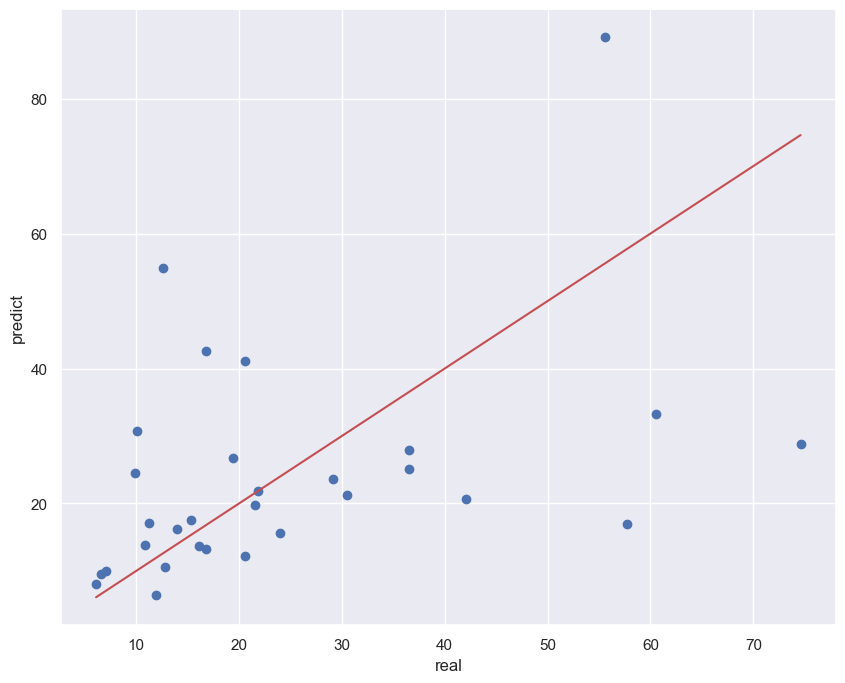

In [71]:
# 성능 확인

xg_model = XGBRegressor()
xg_model.fit(X_tr_1, y_tr_1)
predictions = xg_model.predict(X_test_1)

plt.scatter(y_test_1, predictions)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], 'r') 
plt.show()
# 값들이 빨간선 주위에 오는것이 좋음

## 교차검증 train

In [72]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae = []
results_rmse = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)

    # MAE 계산
    cv_results_mae = cross_val_score(model, X_tr_1, y_tr_1, cv=kfold, scoring='neg_mean_absolute_error')
    cv_results_mae = -cv_results_mae
    results_mae.append(cv_results_mae)
    
    # RMSE 계산
    cv_results_rmse = cross_val_score(model, X_tr_1, y_tr_1, cv=kfold,  scoring='neg_root_mean_squared_error')
    cv_results_rmse = -cv_results_rmse
    results_rmse.append(cv_results_rmse)

    names.append(name)

# DataFrame 생성
result_pd = pd.DataFrame({
    'Model': names,
    'Mean MAE': [round(result.mean(), 4) for result in results_mae],
    'Std MAE': [round(result.std(), 4) for result in results_mae],
    'Mean RMSE': [round(result.mean(), 4) for result in results_rmse],
    'Std RMSE': [round(result.std(), 4) for result in results_rmse]
})

result_pd

,Model,Mean MAE,Std MAE,Mean RMSE,Std RMSE
0,LinearRegression,14.2119,2.8140,18.6595,4.2423
1,DecisionTreeRegressor,16.4681,3.0140,23.5906,5.5053
2,RandomForestRegressor,12.9193,1.9072,17.9909,3.6003
3,AdaBoostRegressor,12.7799,1.8112,17.7290,3.7883
4,GradientBoostingRegressor,13.0418,2.1253,18.5219,4.0489
5,XGBRegressor,13.7212,1.6720,19.2377,3.3332


## 교차검증 test

In [73]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error

results_mae_test = []
results_rmse_test = []

for name, model in models:
    # MAE 계산
    pred_test = cross_val_predict(model, X_test_0, y_test_0, cv=5)
    mae_test = mean_absolute_error(y_test_0, pred_test)
    results_mae_test.append(mae_test)
    
    # RMSE 계산
    rmse_test = np.sqrt(mean_squared_error(y_test_0, pred_test))
    results_rmse_test.append(rmse_test)

# DataFrame 생성
result_pd_test = pd.DataFrame({
    'Model': names,
    'MAE':  results_mae_test,
    'RMSE': results_rmse_test
})

result_pd_test

,Model,MAE,RMSE
0,LinearRegression,19.275875,24.959726
1,DecisionTreeRegressor,20.460417,29.257595
2,RandomForestRegressor,19.050229,26.637740
3,AdaBoostRegressor,21.543070,30.023989
4,GradientBoostingRegressor,21.868556,30.268790
5,XGBRegressor,21.934990,30.050374


---

# 생각거리 (시행하지  말것!)

- corr로 높은상관관계들 피쳐 몇개만
- 선형회귀분석(1항, 다항)
- 군집없이
- 다양한 모델 한번에 테스트
- 이것에 대한 검증평가
- 결정나무에서 나온 베스트 상관관계이용해보기

In [ ]:
# 데이터를 3개로 나눠도 될까?? 
# DecisionTreeRegressor, RandomForestRegressor으로 중요 특성 찾아 import statsmodels.api as sm /  lm = sm.OLS(y_train, X_train).fit()
# 그리드CV - best찾기 - 옵티마
# pipe라인
# 데이터 전처리
# 평가기준 def함수 
# 학습데이터 늘리기

In [ ]:
lm = sm.OLS(y_train, X_train).fit()
lm.summary()

In [ ]:
pred = lm.predict(X_test)

sns.scatterplot(x=y_test, y=pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', ls='dashed', lw=3

In [ ]:
# 상관이 높은것만 통계적회귀
import statsmodels.api as sm

X= merged_data_result[]
y= merged_data_result['RAIV']

In [ ]:
# 상수항 넣기
X= np.c_[X, [1]*len(X)]
X[:5]

lm = sm.OLS(y, X).fit()
lm.summary()

# ols?? #잔차 확인? resid
# R-squared

In [ ]:
pred = lm.predict(X)

sns.scatterplot(x=X[:,0], y=y)
plt.plot(X[:,0], pred, 'r', ls='dashed', lw=3);

In [ ]:
# 참값, 예측값 -> y=x 기울기가 1인 선이 모여있으면 좋음
sns.scatterplot(x=y, y=pred)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r', ls='dashed', lw=3);

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def train_decision_tree(X, y, max_depth=None, min_samples_split=2):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X, y)
    return model

def train_random_forest(X, y, n_estimators=100, max_depth=None, min_samples_split=2):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X, y)
    return model

# 예시
decision_tree_model = train_decision_tree(X_train, y_train, max_depth=5)
random_forest_model = train_random_forest(X_train, y_train)

In [ ]:
# 성능평가?
- R-squared가 높을수록좋음 => 너무 믿으면 안됨 / AIC 낮을수록 좋음 - 모델이 데이터에 잘 반영되었다는 측정하기위한 도구

# 모델평가 RMS
from sklearn.metrics import mean_squared_error
pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)
rms_tr = (np.sqrt(mean_squared_error(y_train, pred_tr)))
rms_test = (np.sqrt(mean_squared_error(y_test, pred_test)))

print('RMS of Train : ',rms_tr)
print('RMS of Test : ',rms_test)